In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
from IPython.display import HTML, clear_output

import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [4]:
from uni_bracketbot_env import Uni_Balance_BracketBot
# from bracketbot_env import UniBalance_BracketBot # alt environment

envs.register_environment("Balance_BracketBot", Uni_Balance_BracketBot)
env = envs.get_environment("Balance_BracketBot")

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

ROLLOUT_LENGTH = 1000

/Users/magi/Code/robots/.venv/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


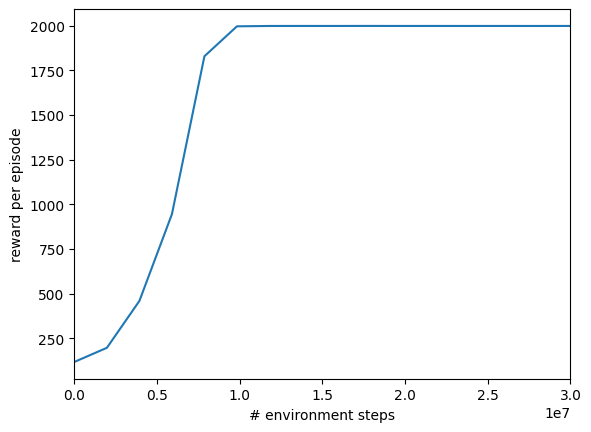

Time to Train: 184.069797 mins.


In [5]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=30_000_000, 
    num_evals=20,
    reward_scaling=10, 
    episode_length=1000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, 
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, 
    batch_size=2048,
    seed=0 
)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()

time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()
print(f"Time to Train: {(time_end - time_start) / 60:2f} mins.")

inference_fn = make_inference_fn(params) 

In [6]:
model.save_params("bracket_policy_balance_uni", params)
params = model.load_params("bracket_policy_balance_uni")

In [10]:
rng = jax.random.PRNGKey(1)
jit_inference_fn = jax.jit(inference_fn)
state = jit_reset(rng)

rollout = [state.pipeline_state]

for i in range(ROLLOUT_LENGTH):
    act_rng, rng = jax.random.split(rng)

    action, _  = inference_fn(state.obs, act_rng)
    done = state.done
    state = jit_step(state, action)

    if done:
        state = jit_reset(rng)

    rollout.append(state.pipeline_state)

    
# html_content = html.render(env.sys, rollout)
# with open('untrained_rollout.html', 'w') as out:
#     out.write(html_content)  
HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))